### Question 1

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

1) We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

2) Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

3) When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following outputs:

1) The kernel after parameter optimization and fitting to the observed data.

2) The log marginal likelihood of the training data.  

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values).

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location?

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values.


Transforming y by taking the log and subtracting mean of 8.40834258589 

The kernel is 0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568) with a log marginal likelihood value of -1364.40499294


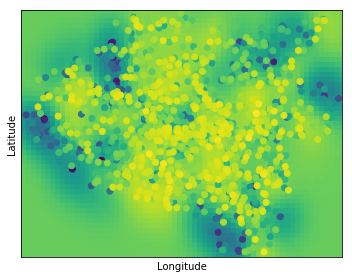

Proportion of anomalous points is 0.0421524663677


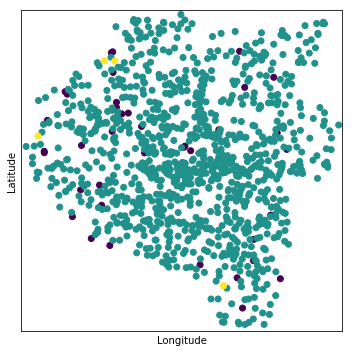

In [1]:
# Solution follows:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

Data1=pd.read_csv("PittsburghTrafficCounts.csv")

# longitude and latitude of each sensor
X = Data1.iloc[:,0:2].values

# average daily traffic count of each sensor
y = np.log(Data1.iloc[:,2].values)
themean = y.mean()
y -= themean
print "Transforming y by taking the log and subtracting mean of", themean, "\n"

# define the kernel and the Gaussian process
kernel = 1 * RBF(length_scale=(0.01, 0.01)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10,random_state=1)

# Fit to the data using maximum likelihood estimation of the parameters
gp.fit(X, y)

print "The kernel is", gp.kernel_, "with a log marginal likelihood value of", gp.log_marginal_likelihood_value_

# predictions for the given points 
y_pred, sigma = gp.predict(X, return_std=True)

# predictions on a mesh
x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

# first figure shows the true y points and our predictions on the mesh
plt.figure(figsize=(5, 5))
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower", vmin=y.min(), vmax=y.max())
plt.scatter(X[:, 0], X[:, 1], c=y, vmin=y.min(), vmax=y.max())
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()

# second figure shows standardized residuals at each point
z2=(y-y_pred)/sigma
print "Proportion of anomalous points is", (abs(z2)>2).sum()/(0.0+len(z2))

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=(1.0*(z2>2)-1.0*(z2<-2)), vmin=-1, vmax=1)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.tight_layout()
plt.show()


### Question 2: Cluster-based anomaly detection

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1
B: 150 points, center (35, 2), standard deviation 5
C: 2 points, center (15, 20), standard deviation 1
D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Circle “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point.

(1, 0)		Anomaly / Not Anomaly


(35, 5)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


### Solution to Question 2:

(1,0) is mapped to Cluster A but is 10 standard deviations away, so it is an anomaly.

(35,2) is mapped to cluster B and is 0.6 standard deviations away, so it is not an anomaly.

(15,19) is mapped to cluster C which is a tiny cluster (only 2 points), so it is an anomaly.

(10,11) is mapped to cluster D and is 1 standard deviation away, so it is not an anomaly.

### Question 3: Anomaly detection (5pts+10pts+10pts+10pts+10pts+5pts)

For this question, use the "County Health Indicators dataset" provided to identify the most anomalous counties. Please list the top 5 most anomalous counties by following models: 

Data preprocessing hints: a. convert the strings to float(except the first column). b. drop all nan's. 

(1) Pick up 6 features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'",
             "'Average Daily PM2.5'"] and use pd.cut() to categorize each feature into 5 categories: 0,1,2,3,4. 

a. Use HillClimbSearch and BicScore to learn the baysian network structure. 

b. Which 5 counties have lowest logliklihood values? Please show the counties' name with its loglikelihood values. 

(2) Cluster based anomaly detection.

a.Cluster with k-means. Please set k= 3.Compute each record's distance to the nearest cluster center and report the five counties which have top five highest distances.

b. Cluster with Gaussian Mixture. Please repeat (2)a but use loglikelihood for each record.

(3) Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you choose. 

(4) Compare and contrast the results from different models, and provide some intuitions on why each county was found to be anomalous.  




In [54]:
import pandas as pd
import numpy as np
Data3=pd.read_csv("https://serv.cusp.nyu.edu/classes/ML_2016_Spring/ML_2017/2016CountyHealthIndicators.csv")
Data3.columns

Index([u'County', u''\% Reporting Fair/Poor Health'',
       u''Physically Unhealthy Days Per Month'',
       u''Mentally Unhealthy Days Per Month'', u''\% Low birth weight births'',
       u''\% Smokers'', u''\% Obese'', u''Food Environment Index'',
       u''\% Physically Inactive'', u''\% With Access To Exercise'',
       u''\% Excessive Drinking'', u''\% Alcohol-Impaired Driving Deaths'',
       u''Chlamydia Rate'', u''Teen Birth Rate'', u''\% Uninsured'',
       u''Preventable Hosp. Rate'', u''\% Dibetics receiving HbA1c'',
       u''\% Mammography'', u''Graduation Rate'', u''\% Some College'',
       u''\% Unemployed'', u''\% Children in Poverty'',
       u''80/20 Income Ratio'', u''\% Single-Parent Households'',
       u''Association Rate'', u''Violent Crime Rate'', u''Injury Death Rate'',
       u''Average Daily PM2.5'', u''\% Severe Housing Problems'',
       u''\% Drive Alone'', u''\% Long Commute - Drives Alone''],
      dtype='object')

In [55]:
x=Data3.iloc[:,1:]

x=x.apply(pd.to_numeric, args=('coerce',))

x.shape

x=pd.concat((Data3.County,x),axis=1)

x=x.dropna()
x.index=range(len(x))
x.shape

# convert to categorical
xx=[]
for i in range(30):
    a=pd.cut(np.asarray(x)[:,i+1],5,labels=[0,1,2,3,4])
    xx.append(a)
x3=np.asarray(xx).T
x3.shape

x4=pd.DataFrame(x3)
x4.columns=list(Data3.columns)[1:]

x5=x4.loc[:,["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'",
             "'Average Daily PM2.5'"]]
x5.columns=["smokers","obese","crimerate","incomeratio","childrenInPoverty","dailyPM2_5"]

x5.shape

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BdeuScore, K2Score, BicScore
data=x5
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

[('smokers', 'obese'), ('smokers', 'dailyPM2_5'), ('childrenInPoverty', 'incomeratio'), ('childrenInPoverty', 'smokers'), ('crimerate', 'childrenInPoverty')]


In [59]:
x5.shape

(2486, 6)

[('Crime', 'ChildrenPoverty'), ('Smokers', 'Obese'), ('Smokers', 'PM2.5'), ('ChildrenPoverty', 'Smokers'), ('ChildrenPoverty', 'Income')] 

In [15]:
# Defining the model
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

model = BayesianModel(best_model.edges())

# Learing CPDs using Maximum Likelihood Estimators
model.fit(data, estimator=MaximumLikelihoodEstimator)
for cpd in model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)
print model.get_independencies()

CPD of childrenInPoverty:
+----------------------+-----------------+-----------------+-----------------+----------------+--------------+
| crimerate            | crimerate(0)    | crimerate(1)    | crimerate(2)    | crimerate(3)   | crimerate(4) |
+----------------------+-----------------+-----------------+-----------------+----------------+--------------+
| childrenInPoverty(0) | 0.139534883721  | 0.0207468879668 | 0.0181818181818 | 0.0            | 0.0          |
+----------------------+-----------------+-----------------+-----------------+----------------+--------------+
| childrenInPoverty(1) | 0.439793281654  | 0.269709543568  | 0.109090909091  | 0.0            | 0.0          |
+----------------------+-----------------+-----------------+-----------------+----------------+--------------+
| childrenInPoverty(2) | 0.330749354005  | 0.473029045643  | 0.436363636364  | 0.583333333333 | 0.0          |
+----------------------+-----------------+-----------------+-----------------+--------

In [21]:
[('smokers', 'obese'), ('smokers', 'dailyPM2_5'), ('childrenInPoverty', 'incomeratio'), 
 ('childrenInPoverty', 'smokers'), ('crimerate', 'childrenInPoverty')]

def logLiklihood(x,infer):
    b=x['smokers']
    c=x['obese']
    d=x['crimerate']
    e=x['incomeratio']
    f=x['childrenInPoverty']
    g=x['dailyPM2_5']
    return np.log((infer.query(['childrenInPoverty'], evidence={'crimerate': d}) ['childrenInPoverty']).values[f]) \
        + np.log((infer.query(['obese'], evidence={'smokers':b}) ['obese']).values[c]) \
        + np.log((infer.query(['dailyPM2_5'], evidence={'smokers': b}) ['dailyPM2_5']).values[g]) \
        + np.log((infer.query(['smokers'], evidence={'childrenInPoverty': f}) ['smokers']).values[b]) \
        + np.log((infer.query(['incomeratio'], evidence={'childrenInPoverty': f}) ['incomeratio']).values[e]) \
        + np.log((infer.query(['crimerate'])['crimerate']).values[d])

,County,0
1444,"New York, New York",-16.608495
182,"San Francisco, California",-14.827149
1577,"Rolette, North Dakota",-14.686742
1007,"Suffolk, Massachusetts",-14.457849
248,"District of Columbia, District of Columbia",-13.671439


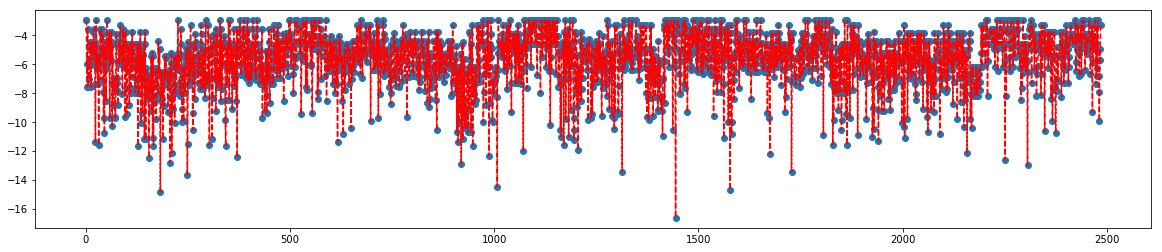

In [22]:
from pgmpy.inference import VariableElimination
import numpy as np
infer = VariableElimination(model)

logLiklihood(data.iloc[0,:],infer)

exmp=data.apply(lambda x: logLiklihood(x,infer),axis=1)

%matplotlib inline
import matplotlib.pylab as plt
plt.figure(figsize=(20,4))
plt.scatter(range(len(exmp)),exmp)
plt.plot(exmp,"r--")

pd.concat((x.County, exmp),axis=1).sort_values(0)[:5]

(2)

If use all features:


In [76]:
x3.shape

(2486, 30)

In [74]:
from sklearn.cluster import KMeans

data3_1=x3
data3=x
data3.index=range(len(data3))
KM = KMeans(n_clusters=3, random_state=999)
KM.fit(data3_1)

res_km = pd.DataFrame(KM.transform(data3_1)).apply(lambda x: min(x), axis=1)
res_km.name = 'distance'
print "============KMeans====================="
print pd.concat([data3['County'], res_km], axis=1).sort_values('distance', ascending=False)[:5]

GM = GaussianMixture(n_components=3, random_state=999)
GM.fit(data3_1)

res_gm = pd.DataFrame(GM.score_samples(data3_1))
res_gm.columns = ['logLikelihood']
print "===========Gaussian====================="
print pd.concat([data3['County'], res_gm], axis=1).sort_values('logLikelihood')[:5]

============KMeans=====================
                       County   distance
1890    Shannon, South Dakota  10.456788
66            Apache, Arizona   7.700208
1417          Bronx, New York   7.356528
1577    Rolette, North Dakota   7.090708
913   East Carroll, Louisiana   6.792613
===========Gaussian=====================
                      County  logLikelihood
1890   Shannon, South Dakota     -77.235154
66           Apache, Arizona     -57.110437
619            Knox, Indiana     -54.336422
1417         Bronx, New York     -53.139231
338   Chattahoochee, Georgia     -51.750459


(2) If use only five features:

In [78]:
from sklearn.cluster import KMeans

data3_1=x5
data3=x
data3.index=range(len(data3))
KM = KMeans(n_clusters=3, random_state=9)
KM.fit(data3_1)

res_km = pd.DataFrame(KM.transform(data3_1)).apply(lambda x: min(x), axis=1)
res_km.name = 'distance'
print "============KMeans====================="
print pd.concat([data3['County'], res_km], axis=1).sort_values('distance', ascending=False)[:5]

GM = GaussianMixture(n_components=3, random_state=9)
GM.fit(data3_1)

res_gm = pd.DataFrame(GM.score_samples(data3_1))
res_gm.columns = ['logLikelihood']
print "===========Gaussian====================="
print pd.concat([data3['County'], res_gm], axis=1).sort_values('logLikelihood')[:5]

============KMeans=====================
                      County  distance
1577   Rolette, North Dakota  4.101951
2158          Willacy, Texas  4.081903
1444      New York, New York  4.019883
2005           Brooks, Texas  3.730120
1007  Suffolk, Massachusetts  3.710527
===========Gaussian=====================
                       County  logLikelihood
1577    Rolette, North Dakota     -23.124834
2158           Willacy, Texas     -16.072453
1562  Watauga, North Carolina     -15.492935
1007   Suffolk, Massachusetts     -15.422194
2348      Whitman, Washington     -15.033217
